*A1 Report - Wu, Sixuan*
# <center> Exploring Toronto Shared Bike Trips </center>
## <center> Author: Sixuan Wu </center>
## <center> Date: February 3rd, 2020 </center>
***

## Introduction

Over past several years, shared bike in the world become more and more popular and the number of shared bikes in cities are increasing sharply. Regarding to the increasing fee of TTC, terrible traffic jam in big cities and horrible air pollution in the world, nothing need to be said about the advantage of shared bike in Toronto. I would like to use python to analysis the data of Toronto shared bikes trips which will provides us with a better insight into the Toronto Shared Bikes trips. According to the result to this report, policies of Toronto Bike Share can be improved and visitors can gain a better experience when they wander in the city of Toronto with shared bikes located in different areas of the city. In this report, I only consider the Share Bikes in Toronto from July in 2016 to December in 2017. In addition, I will figure out the impact of users type of Toronto Share Bikes and weather on trips length.

## Data Description

In this project, I will use several third party data sets as following:
- **[Bike Share Toronto Rideship Data](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/)**: These data sets provides detailed description for every trip from beginning of the third quater in 2016 to the end of the fourth quater in 2017. 
- **[Bike Share Toronto](https://open.toronto.ca/dataset/bike-share-toronto/)**: This dataset gives the information of stations in Toronto. Stations are located in Downtown, Scarborough, North York, and Etobicoke.
- **[Historical Weather Data](https://climate.weather.gc.ca/)**: This offers data of historical weather and I can use this dataset to find the relationship between bikes rideship and weather in 2016 and 2017. 

Here is the [License Agreement](https://climate.weather.gc.ca/prods_servs/attachment1_e.html) on Historcal Climate Data website:

**1.** This data will be only used by me in this report. Cite: This product may only be used by you, and you may not rent, lease, lend, sub-licence or transfer the data product or any of your rights under this agreement to anyone else, except under the following terms and conditions. (In Grant of License of Licence Agreement for Use of Environment and Climate Change Canada Data)

**2.** I declare all information relate to weather in this report are based on Environment and Climate Change Canada data. Cite: You are authorized to further distribute the data or software, including any portion of it, contained in this product under the following conditions only. No fee will be charged explicitly for this Environment and Climate Change Canada product to any party to whom it is distributed. (Charges for value-added services are permitted.). In consideration of the licence you are herein granted, you have the obligation to acknowledge the source of the Environment and Climate Change Canada Data with the following layout or something similar: based on Environment and Climate Change Canada data. Redistribution must occur so that any other party must agree to the same redistribution restrictions before use of the redistributed product is allowed. (In redistribution restrictions of Licence Agreement for Use of Environment and Climate Change Canada Data)

## Research Questions

In this report, I will discuss two questions as following:
- Do casual users take shorter trips compared to members?
- Does season or weather affect trip length?

### Trip Length Definition

Regarding to the data we have, I give two definitions to measure the length of trip: trip duration and trip distance. I use the trip duration which is provided in rideship dataset for trip duration's benchmark with unit second while use station information to caculate the Manhattan distance between stations to measure the trip distance with unit kilometer.

## Data Cleaning

In [1]:
import pandas as pd
from dateutil.parser import parse
from urllib.request import urlopen
import io
import requests
from pandas.io.json import json_normalize
from fuzzywuzzy import fuzz
import numpy as np
from bs4 import BeautifulSoup
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\wusix\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Read data from csv and xlsx files
q1_2017 = pd.read_csv('Bikeshare Ridership (2017 Q1).csv')
q2_2017 = pd.read_csv('Bikeshare Ridership (2017 Q2).csv')
q3_2017 = pd.read_csv('Bikeshare Ridership (2017 Q3).csv')
q4_2017 = pd.read_csv('Bikeshare Ridership (2017 Q4).csv')
q3_2016 = pd.read_excel('bikeshare-ridership-2016-q3.xlsx')
q4_2016 = pd.read_excel('bikeshare-ridership-2016-q4.xlsx')


### Reformat Date Time

As we observe the **trip_start_time** and **trip_stop_time** in rideship dataset are not in the same format. In the third quater in 2017 and fourth quater in 2016, date times are stored as dd/mm/yy. However, in other datasets, date times are stored as mm/dd/yy. Therefore, it is necessary to format them in a same way.

In addition, when dealing with the date time format, there is a date time is not provided in trip_stop_time in the fourth quater in 2017. Then I delete that data in the date frame.

In the end, I concatenate all data frames and create a new data frame which contains all information of trips.

In [3]:
# Reformat trip start time and stop time in 2017 data set.

# parse time in quater 1 in 2017 
q1_2017.trip_start_time = q1_2017.trip_start_time.apply(lambda x: parse(x, dayfirst=False) if isinstance(x, str) else x)
q1_2017.trip_stop_time = q1_2017.trip_stop_time.apply(lambda x: parse(x, dayfirst=False) if isinstance(x, str) else x)
q1_2017['date'] = [q1_2017.trip_start_time[i].date() for i in range(len(q1_2017))]

# parse time in quater 2 in 2017 
q2_2017.trip_start_time = q2_2017.trip_start_time.apply(lambda x: parse(x, dayfirst=True) if isinstance(x, str) else x)
q2_2017.trip_stop_time = q2_2017.trip_stop_time.apply(lambda x: parse(x, dayfirst=True) if isinstance(x, str) else x)
q2_2017['date'] = [q2_2017.trip_start_time[i].date() for i in range(len(q2_2017))]

# parse time in quater 3 in 2017 
q3_2017.trip_start_time = q3_2017.trip_start_time.apply(lambda x: parse(x, dayfirst=False) if isinstance(x, str) else x)
q3_2017.trip_stop_time = q3_2017.trip_stop_time.apply(lambda x: parse(x, dayfirst=False) if isinstance(x, str) else x)
q3_2017['date'] = [q3_2017.trip_start_time[i].date() for i in range(len(q3_2017))]

# There is data without trip_stop_time in quater 4 in 2017
q4_2017 = q4_2017[q4_2017.trip_stop_time != 'NULLNULL'].reset_index()
q4_2017.pop('index')

# parse time in quater 4 in 2017 
q4_2017.trip_start_time = q4_2017.trip_start_time.apply(lambda x: parse(x, dayfirst=False) if isinstance(x, str) else x)
q4_2017.trip_stop_time = q4_2017.trip_stop_time.apply(lambda x: parse(x, dayfirst=False) if isinstance(x, str) else x)
q4_2017['date'] = [q4_2017.trip_start_time[i].date() for i in range(len(q4_2017))]

q1_2017.to_csv('q1_2017.csv', index=False)
q2_2017.to_csv('q2_2017.csv', index=False)
q3_2017.to_csv('q3_2017.csv', index=False)
q4_2017.to_csv('q4_2017.csv', index=False)


In [4]:
# parse time in quater 3 in 2016 
q3_2016.trip_start_time = q3_2016.trip_start_time.apply(lambda x: parse(str(x), dayfirst=False))
q3_2016.trip_stop_time = q3_2016.trip_stop_time.apply(lambda x: parse(str(x), dayfirst=False))
q3_2016['date'] = [q3_2016.trip_start_time[i].date() for i in range(len(q3_2016.trip_start_time))]

# parse time in quater 4 in 2016 
q4_2016.trip_start_time = q4_2016.trip_start_time.apply(lambda x: parse(str(x), dayfirst=True))
q4_2016.trip_stop_time = q4_2016.trip_stop_time.apply(lambda x: parse(str(x), dayfirst=True))
q4_2016['date'] = [q4_2016.trip_start_time[i].date() for i in range(len(q4_2016.trip_start_time))]

q3_2016.to_csv('q3_2016.csv', index=False)
q4_2016.to_csv('q4_2016.csv', index=False)


In [5]:
q1_2017 = pd.read_csv('q1_2017.csv')
q2_2017 = pd.read_csv('q2_2017.csv')
q3_2017 = pd.read_csv('q3_2017.csv')
q4_2017 = pd.read_csv('q4_2017.csv')
q3_2016 = pd.read_csv('q3_2016.csv')
q4_2016 = pd.read_csv('q4_2016.csv')

In [6]:
# Concatenate datasets and save locally which can be used in future easily.
trips = pd.concat([q1_2017, q2_2017, q3_2017, q4_2017, q3_2016, q4_2016], join='inner')
trips.to_csv('all_trips.csv', index=False)

In [7]:
trips = pd.read_csv('all_trips.csv')

### Delete Invalid Rideship

We can observe that there some data in the dataset are with really little short trip duration and the from station and destination station are at the same place. I suppose that the reason of the existence of these data is the user unlock bikes by mistake, which means the user did not want to use bike. Therefore, to make data be more valid, I delete those rideship within 1 minutes.

In [8]:
trips = trips[trips.trip_duration_seconds >= 60]

### Remove Outliers

There also some outliers in the rideship dataset, therefore, it is necessary to remove those outliers in the dataset.

In [9]:
def remove_outliers(col):
    
    """
    Remove outliers in the trips dataset.
    """
    
    q1 = trips[col].quantile(0.25)
    q3 = trips[col].quantile(0.75)
    iqr = q3 - q1
    return trips[(trips[col] > q1 - 1.5 * iqr) & (trips[col] < q3 + 1.5 * iqr)].reset_index(drop=True)

trips = remove_outliers('trip_duration_seconds')

### Match to Station Information

Here I use dataset of stations information, for each ridetrip, I find information of from stations and destination stations in the dataset. However, when we match stations name, some of stations share different names but actually they are same. Therefore, I will use python to find out those stations and rename them such that they will use same names which is necessary for further analysis. Below is the station information we have.

In [10]:
# Read stations information from json
url = 'https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information'
s = requests.get(url)
station = json_normalize(s.json())
station = pd.DataFrame(station['data.stations'][0])
station

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,rental_methods,groups,obcn,nearby_distance,post_code,cross_street
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],647-643-9607,500.00,NaN,NaN
1,7001,Lower Jarvis St / The Esplanade,REGULAR,43.647992,-79.370907,0.0,Lower Jarvis St / The Esplanade,15,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],416-617-9576,500.00,NaN,NaN
2,7002,St. George St / Bloor St W,REGULAR,43.667333,-79.399429,0.0,St. George St / Bloor St W,19,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],647-643-9615,500.00,NaN,NaN
3,7003,Madison Ave / Bloor St W,REGULAR,43.667158,-79.402761,NaN,Madison Ave / Bloor St W,15,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],647-631-4587,500.00,NaN,NaN
4,7004,University Ave / Elm St,REGULAR,43.656518,-79.389099,NaN,University Ave / Elm St,11,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[P7004-7047],647-643-9673,500.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,7505,Ontario St / Adelaide St E -SMART,SMARTMAPFRAME,43.652458,-79.366433,0.0,Ontario St / Adelaide St E -SMART,19,"[KEY, TRANSITCARD, PHONE]",[SMART MAP FRAME],437-243-9011,1609.34,M5A 1N5,NaN
459,7506,Berkeley St / Adelaide St E - SMART,SMARTMAPFRAME,43.653359,-79.365023,0.0,Berkeley St / Adelaide St E - SMART,12,"[KEY, TRANSITCARD, PHONE]","[SMART MAP FRAME, P7506-7356]",437-688-8179,1609.34,M5A 2W7,NaN
460,7508,Berkeley St / Dundas St E - SMART,SMARTMAPFRAME,43.658816,-79.367318,0.0,Berkeley St / Dundas St E - SMART,17,"[KEY, TRANSITCARD, PHONE]","[SMART MAP FRAME, P7109-7508]",437-243-9390,1609.34,M5A 2A7,NaN
461,7509,Ontario St / King St E,REGULAR,43.651814,-79.366194,0.0,Ontario St / King St E,19,"[KEY, CREDITCARD, TRANSITCARD, PHONE]",[],437-241-5483,500.00,NaN,NaN


First, I find the stations appear in rideship dataset but not in the station information dataset. Then for each station in rideship butnot in station information, I find the most similar one in station information by using **fuzzywuzzy** package in python. In the end, I compare those stations whether they are same and replace name in the rideship dataset by the name in station information dataset. Those stations without any information in the information dataset are dropped finally because I cannot define the trip distance without any station information.

However the limitation of this method is if there exists stations with totally different name but they are actually same ones, those station will be ignored in the further data analysis.

In [11]:
# Find data appear in rideship dataset but not in stations information dataset.
trip_stations = set(trips.from_station_name).union(set(trips.to_station_name))
info_stations = set(station.name)
diff = trip_stations - info_stations - set([np.nan])
print(diff)


{'Widmer St / Adelaide St ', 'Wellesley St E / Yonge St Green P', 'College St W / Huron St', 'College St W / Borden St', 'Michael Sweet Ave / St. Patrick St', 'Lake Shore Blvd W / Ontario Dr(Ontario Place)', '25 York St (ACC/Union Station South)', 'Lake Shore Blvd W / Windermere Ave', 'Beverly St / College St', 'Dundas St / Yonge St', 'Base Station', 'Front St / Yonge St (Hockey Hall of Fame)', 'Summerhill Ave / MacLennan Ave - SMART', 'St George St / Bloor St W', 'Lower Spadina Ave / Lake Shore Blvd', 'Bloor GO / UP Station/ Rail Path', 'Fort York  Blvd / Capreol Crt', 'Simcoe St / Dundas St W', 'Landsdowne Subway Green P', 'Front St / Bay St (North Side)', 'Lansdowne Subway Green P', 'Stephenson Ave / Main St', 'College St W / Markham St', 'Rusholme Park Cres / College St W', 'Beverly  St / Dundas St W', 'Sherbourne St / Wellesley St', 'Princess St / Adelaide St', '424 Wellington St. W', 'Temperance St / Yonge St', 'Simcoe St / Wellington St W', 'Beverly St / College St W', 'Ontario 

Following dictionary stores the stations in rideship dataset can be replaced by a new name which can be found in station information dataset.

In [12]:
# For the station cannot be found in stations information, find the most similar station in the information dataset.
similar = {}
for d in diff:
    ratio_dict = {}
    for s in info_stations:
        ratio_dict[s] = fuzz.ratio(s, d)
    similar[(d, max(ratio_dict, key=ratio_dict.get))] = ratio_dict[max(ratio_dict, key=ratio_dict.get)]

# If fuzz ratio is greater or equal to 85, they can be regarded as same station.
valid_station_names = {}
for tup in similar:
    if similar[tup] >= 85:
        valid_station_names[tup[0]] = tup[1]

valid_station_names

{'Widmer St / Adelaide St ': 'Widmer St / Adelaide St W',
 'Wellesley St E / Yonge St Green P': 'Wellesley St E / Yonge St (Green P)',
 'College St W / Huron St': 'College St / Huron St',
 'College St W / Borden St': 'College St / Borden St',
 '25 York St (ACC/Union Station South)': '25 York St – Union Station South',
 'Lake Shore Blvd W / Windermere Ave': 'Lakeshore Blvd W / Windermere Ave',
 'Beverly St / College St': 'Beverley St / College St',
 'Dundas St / Yonge St': 'Dundas St W / Yonge St',
 'Front St / Yonge St (Hockey Hall of Fame)': 'Front St W / Yonge St (Hockey Hall of Fame)',
 'Summerhill Ave / MacLennan Ave - SMART': 'Summerhill Ave / Maclennan Ave',
 'St George St / Bloor St W': 'St. George St / Bloor St W',
 'Lower Spadina Ave / Lake Shore Blvd': 'Lower Spadina Ave / Lakeshore Blvd',
 'Fort York  Blvd / Capreol Crt': 'Fort York  Blvd / Capreol Ct',
 'Front St / Bay St (North Side)': 'Front St W / Bay St (North Side)',
 'College St W / Markham St': 'College St / Markham 

In [13]:
# Replace by new name.
trips.from_station_name = trips.from_station_name.apply(lambda x: valid_station_names[x] if x in valid_station_names else x)
trips.to_station_name = trips.to_station_name.apply(lambda x: valid_station_names[x] if x in valid_station_names else x)

# Drop the data with stations whose information cannot be found.
data = trips[trips.from_station_name.apply(lambda x: x in info_stations) & trips.to_station_name.apply(lambda x: x in info_stations)].reset_index(drop=True)


### Calculate Distance for Rideship

After finding trips for each station, I will calculate the distance of each trip because the distance of each trip is one of the benchmark to measure the length of the trips. In order to find those distance, I use [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to calculate the straight distance. Since there is an angle between Toronto and the real east-west. Then to calculate the Manhattan distance, I use the straight distance mutiply by $cos(17^{o}) + sin(17^{o})$.

Nevertheless, there is limitation to calculate distance in this way. The method I use is the mathematical way to calculate the distance between stations, it is not the actual distance of the trip. Then for those people who ride bike from a station and take a round trip in the city and put the bike back to the station, this algorithm will regard the distance as 0km. Besides that, not all people ride bikes in Manhattan distance. Tourists may take a detour because of they are not fammilar with the city or they would like to go sightseeing by bike in the city. 

Dataset below shows the dataframe with distance calculated from start station and stop station.

In [14]:
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

haversine(station.lon[0], station.lat[0], station.lon[1], station.lat[1])
distance = []
station_usable = {}

# Build a new dictionary whose keys are stations' names and value is the tuple of exact location.
for i in range(len(station)):
    station_usable[station.name[i]] = (station.lon[i], station.lat[i])
    
# Find the distance between each from station and destination station
rad = math.radians(17)
constant = math.cos(rad) + math.sin(rad)
for i in range(len(data)):
    straight = haversine(station_usable[data.from_station_name[i]][0], station_usable[data.from_station_name[i]][1], 
                        station_usable[data.to_station_name[i]][0], station_usable[data.to_station_name[i]][1])
    distance.append(constant * straight)

# Combine dataset with the distance according to the start station and stop station.
data['distance(km)'] = distance

In [15]:
data.rename(columns={'distance': 'distance(km)'}, inplace=True)
data.to_csv('all_data_with_distance.csv', index=False)


In [16]:
data = pd.read_csv('all_data_with_distance.csv')
data

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type,date,distance(km)
0,712382,2017-01-01 00:00:00,2017-01-01 00:03:00,223,Wellesley St E / Yonge St (Green P),Church St / Wood St,Member,2017-01-01,0.491877
1,712383,2017-01-01 00:00:00,2017-01-01 00:05:00,279,Kendal Ave / Bernard Ave,Bathurst Subway Station,Member,2017-01-01,0.752303
2,712384,2017-01-01 00:05:00,2017-01-01 00:29:00,1394,Parliament St / Aberdeen Ave,College St / Markham St,Member,2017-01-01,4.283291
3,712385,2017-01-01 00:07:00,2017-01-01 00:21:00,826,College Park South,King St W / Spadina Ave,Member,2017-01-01,2.353428
4,712386,2017-01-01 00:08:00,2017-01-01 00:12:00,279,McGill St / Church St,University Ave / Gerrard St W,Member,2017-01-01,1.094332
...,...,...,...,...,...,...,...,...,...
1641140,712376,2016-12-31 23:21:00,2016-12-31 23:28:00,410,Queen St W / Spadina Ave,Simcoe St / Wellington St North,Member,2016-12-31,1.083824
1641141,712377,2016-12-31 23:26:00,2016-12-31 23:39:00,824,Union Station,Gould St / Mutual St,Member,2016-12-31,1.784949
1641142,712378,2016-12-31 23:26:00,2016-12-31 23:34:00,478,Bay St / College St (East Side),Beverley St / Dundas St W,Member,2016-12-31,1.319888
1641143,712380,2016-12-31 23:37:00,2016-12-31 23:58:00,1253,Christie St / Benson Ave (Wychwood Barns),Wellesley St E / Yonge St (Green P),Member,2016-12-31,4.649139


### Scrape Data of Weather

To gain data of weather, I scrape the data from Historical Weather Data of Canada Government which is mentioned in the data description section before. The package I used is BeautifulSoup from bs4 in python. Then the weather data is as following:

In [17]:
def scrape_data(month, year):
    
    """
    This function is used to scrape data on the website according to
    the specific month and year.
    """
    
    data = []
    html = urlopen('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=' + str(year) + '&Month=' + str(month))
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table', attrs={'class': 'table table-striped table-hover align-cells-right data-table'})
    
    # Scrape table head data.
    table_title = table.find('thead').find('tr')
    titles = table_title.find_all('th')
    titles_lst = []
    for title in titles[1:]:
        title = title.find('a')
        title = title.get_text().strip()
        if title is not None:
            titles_lst.append(title)

    # Scrape table body data.
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    rows_list = []
    for row in rows[:-4]:
        row_elements = row.find_all('td')
        rows_list.append([row_elements[i].get_text().strip() for i in range(len(row_elements))])

    # Create dataframe and add date to the dataframe
    df = pd.DataFrame(rows_list, columns=titles_lst)
    df['date'] = [date for date in range(1, len(df) + 1)]
    df.date = df.date.apply(lambda x: datetime.datetime(year=year, month=month, day=x))
    return df

In [18]:
# Concatenate dataframes of 2016 and 2017.
dfs_2017 = [scrape_data(i, 2017) for i in range(1, 13)]
dfs_2016 = [scrape_data(i, 2016) for i in range(7, 13)]
dfs_2017.extend(dfs_2016)
weather = pd.concat(dfs_2017).reset_index(drop=True)
weather

,Max Temp Definition,Min Temp Definition,Mean Temp Definition,Heat Deg Days Definition,Cool Deg Days Definition,Total Rain,Total Snow,Total Precip Definition,Snow on Grnd Definition,Dir of Max Gust Definition,Spd of Max Gust Definition,date
0,1.8,-2.5,-0.4,18.4,0.0,0.0,0.0,0.0,3,27,50,2017-01-01
1,4.8,-4.1,0.4,17.6,0.0,LegendTT,0.0,LegendTT,2,10,35,2017-01-02
2,4.4,1.7,3.1,14.9,0.0,15.8,0.0,15.8,LegendTT,,<31,2017-01-03
3,3.5,-8.5,-2.5,20.5,0.0,0.2,LegendTT,0.2,LegendTT,27,80,2017-01-04
4,-6.5,-11.9,-9.2,27.2,0.0,0.0,LegendTT,LegendTT,LegendTT,25,56,2017-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...
544,6.7,-3.1,1.8,16.2,0.0,0.0,0.2,LegendTT,1,26,70,2016-12-27
545,0.6,-3.7,-1.6,19.6,0.0,0.0,LegendTT,LegendTT,1,26,43,2016-12-28
546,1.9,-1.6,0.2,17.8,0.0,0.0,6.0,6.0,5,28,44,2016-12-29
547,-0.1,-3.6,-1.9,19.9,0.0,0.0,0.4,0.4,5,29,46,2016-12-30


It is not to notice that in the dataframe we get, there are some cells with "LegendTT" or "LegendMM". By checking the document on the website, I use 0 to replace "LegendTT" and use np.nan to replace "LegendMM". In addition, I found that all of these cells contains data with string type, then I convert them into float type if they can be converted. Some of them cannot be converted such as "<31". Then for those cells, they are not cast into float type but just still exists as string type.

After cleanning weather data, the cleaned weather data is as following:

In [19]:
def clean_weather(x):

    """
    This function is used to clean the data of 
    the weather dataset.
    """
    
    try:
        if x == '':
            return np.nan

        ret = float(x)
        return ret
    except:
        if 'TT' in x:
            return 0.0
        elif 'MM' in x:
            return np.nan
        elif 'EE' in x:
            return x.strip('LegendEE')
        elif '<' in x:
            return x

# Clean data in each column.
for col in weather:
    if col != 'date':
        weather[col] = weather[col].apply(lambda x: clean_weather(x))
weather

,Max Temp Definition,Min Temp Definition,Mean Temp Definition,Heat Deg Days Definition,Cool Deg Days Definition,Total Rain,Total Snow,Total Precip Definition,Snow on Grnd Definition,Dir of Max Gust Definition,Spd of Max Gust Definition,date
0,1.8,-2.5,-0.4,18.4,0,0.0,0.0,0,3.0,27.0,50,2017-01-01
1,4.8,-4.1,0.4,17.6,0,0.0,0.0,0,2.0,10.0,35,2017-01-02
2,4.4,1.7,3.1,14.9,0,15.8,0.0,15.8,0.0,NaN,<31,2017-01-03
3,3.5,-8.5,-2.5,20.5,0,0.2,0.0,0.2,0.0,27.0,80,2017-01-04
4,-6.5,-11.9,-9.2,27.2,0,0.0,0.0,0,0.0,25.0,56,2017-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...
544,6.7,-3.1,1.8,16.2,0,0.0,0.2,0,1.0,26.0,70,2016-12-27
545,0.6,-3.7,-1.6,19.6,0,0.0,0.0,0,1.0,26.0,43,2016-12-28
546,1.9,-1.6,0.2,17.8,0,0.0,6.0,6,5.0,28.0,44,2016-12-29
547,-0.1,-3.6,-1.9,19.9,0,0.0,0.4,0.4,5.0,29.0,46,2016-12-30


## Data Visualization

### Relation Between Trip Duration and Trip Distance

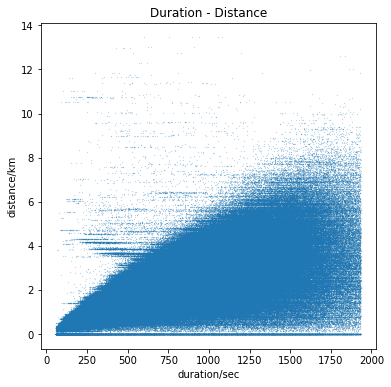

In [20]:
plt.figure(figsize=(6, 6))
plt.title('Duration - Distance')
plt.xlabel('duration/sec')
plt.ylabel('distance/km')
plt.plot(data.trip_duration_seconds, data['distance(km)'], 'o', markersize=0.1)
plt.show()

According to the scatter plot above, it is interesting to notice that there is a "upper bound" of the distance according to each duration and this "upper bound" share the linear relationship to the trip duration. Since I calculate the distance as the Manhattan distance to measure the distance, and the limitation of this methods have been mentioned before, it is not surprised to find the scatter plot is in this shape.

For those points below that "upper bound" represents the people that take detour. I suppose that "upper bound" will be the normal speed of people to ride bike that is the linear coefficient of the "upper bound" will be the speed of bike ride. However, the upper bound is not strictly linear, and the coefficient is become smaller, this indicates most people will ride slower when they ride for longer distance. Those points above the upper bound implies that there is not too many people ride this bikes at really fast speed because if a person want to ride bike to do exercise, the person will not choose share bike as the fee need to be paid and the quality of the bikes.

### Do casual users take shorter trips compared to members?

By common sense, members should take longer trips than casual users because they may have discount or they have bought combos. Then, I will analysis this research question based on two questions of trip length I gave before.

In [21]:
member_type_duration = data[['trip_duration_seconds', 'user_type']]
member_type_distance = data[['distance(km)', 'user_type']]

#### Duration

In [22]:
casual = member_type_duration[member_type_duration['user_type'] == 'Casual']
member = member_type_duration[member_type_duration['user_type'] == 'Member']
print('Casual users data summary shared as below:')
print(casual.trip_duration_seconds.describe())
print()
print('Member users data summary shared as below:')
print(member.trip_duration_seconds.describe())

Casual users data summary shared as below:
count    293228.000000
mean        984.684914
std         433.812570
min          60.000000
25%         644.000000
50%         960.000000
75%        1311.000000
max        1933.000000
Name: trip_duration_seconds, dtype: float64

Member users data summary shared as below:
count    1.347917e+06
mean     6.523719e+02
std      3.471004e+02
min      6.000000e+01
25%      3.910000e+02
50%      5.840000e+02
75%      8.520000e+02
max      1.933000e+03
Name: trip_duration_seconds, dtype: float64


According to the summary of data, it is unexpected that the number of member user are extremely larger than the number of casual user. However, based on trip duration, member user have less time to ride bikes than those casual users.

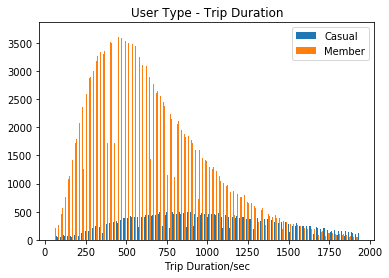

In [23]:
plt.title('User Type - Trip Duration')
plt.xlabel('Trip Duration/sec')
plt.hist([casual.trip_duration_seconds, member.trip_duration_seconds], 1000, histtype='bar', label=['Casual', 'Member'])
plt.legend(loc='upper right')
plt.show()

I use histogram to show the difference of the casual and member distributions first. Based on the histogram above, the variance of casual users are larger than member users, which means the trip duration of member users use share bike are "closer". This may indicate member user are more familliar to the city and do not need to spend long time to go sightseeing in the city. 

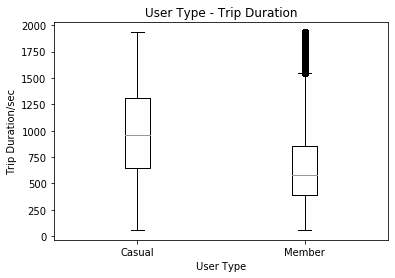

In [24]:
plt.title('User Type - Trip Duration')
plt.xlabel('User Type')
plt.ylabel('Trip Duration/sec')
plt.boxplot([casual.trip_duration_seconds, member.trip_duration_seconds], labels=['Casual', 'Member'])
plt.show()

This boxplot can indicate the distribution of different user type with trip duration seconds more obviously. When cleaning dataset, outliers in this dataset has been removed. We can still notice that there are some outliers for member user type when the trip duration is long while those outliers cannot be found for casual users. However, the height of these two boxplot are almost same. I can conclude casual member is more likely to take longer rideship. 

I suppose the reason cause this phenomenon is casual users are people who do not live in Toronto since if they live in Toronto and they want to use the bike often, the person can apply for a member. Therefore, some of them must be tourist, when they use bikes in the city, they may want to go sightseeing or they are not familliar with this city, these reasons make them take a detour. Therefore, they may take longer duration than those members who are familliar with the city.

#### Distance

Now I will analysis the relationship between user type and trip duration based on trip distance. To make the result more clear, I discard all data with distance 0 km which means the user take and give bake the bike to same position even if the user used the bike and go around the city. In this way, it is easier to see the mean value and to compare the relationship between user type and trip distance.

In [25]:
member_type_distance = member_type_distance[member_type_distance['distance(km)'] != 0]
casual = member_type_distance[member_type_distance['user_type'] == 'Casual']
member = member_type_distance[member_type_distance['user_type'] == 'Member']
print('Casual users data summary shared as below:')
print(casual['distance(km)'].describe())
print()
print('Member users data summary shared as below:')
print(member['distance(km)'].describe())


Casual users data summary shared as below:
count    280097.000000
mean          2.270337
std           1.256352
min           0.031020
25%           1.352598
50%           2.056533
75%           2.951498
max          13.452779
Name: distance(km), dtype: float64

Member users data summary shared as below:
count    1.333863e+06
mean     2.107353e+00
std      1.198732e+00
min      3.102047e-02
25%      1.220676e+00
50%      1.860473e+00
75%      2.739388e+00
max      1.345278e+01
Name: distance(km), dtype: float64


Intuitively, by comparing the mean value of each dataset, mean value of member users and casual users are almost same.

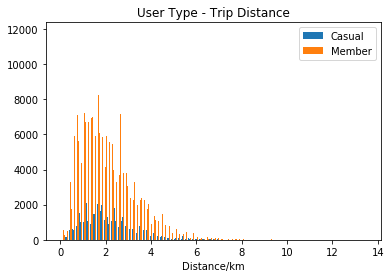

In [26]:
plt.title('User Type - Trip Distance')
plt.xlabel('Distance/km')
plt.hist([casual['distance(km)'], member['distance(km)']], 1000, label=['Casual', 'Member'])
plt.legend(loc='upper right')
plt.show()

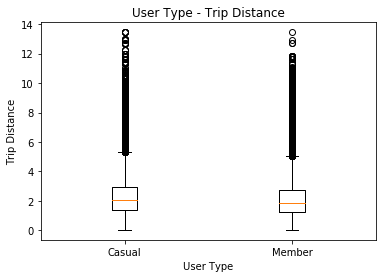

In [27]:
plt.title('User Type - Trip Distance')
plt.xlabel('User Type')
plt.ylabel('Trip Distance')
plt.boxplot([casual['distance(km)'], member['distance(km)']], labels=['Casual', 'Member'])
plt.show()

Based on the histogram and boxplot above, the distributions of casual user type and member user type are almost same. We cannot say which one are more likely to ride bikes for a long distance. 

### Does season or weather affect trip length?

In this part, I will analysis the season and weather impact on the trip length according to the two definitions I gave. 

In [28]:
# Modify weather dataframe to a dictionary whose keys are dates.
pd.Timestamp(data.trip_start_time[0]).date() == weather.date[0].date()
weather_length = []
weather_dict = {}
for i in range(len(weather)):
    lst = []
    for col in weather:
        if col == 'date' or col == 'Spd of Max Gust Definition':
            continue
        else:
            lst.append(weather[col][i])
    weather_dict[weather['date'][i].date()] = lst

# Combine trip duration and distance together and buid a new dataframe.
col = weather.columns.to_list()
col.remove('Spd of Max Gust Definition')
col.remove('date')
col.append('trip_duration_seconds')
col.append('distance(km)')
for i in range(len(data)):
    lst = weather_dict[pd.Timestamp(data.trip_start_time[i]).date()].copy()
    lst.append(data.trip_duration_seconds[i])
    lst.append(data['distance(km)'][i])
    weather_length.append(lst)


In [29]:
weather_length_df = pd.DataFrame(np.array(weather_length[:250000]), columns=col)

# Find correlation coefficient.
weather_length_corr = weather_length_df.corr()
weather_length_corr

,Max Temp Definition,Min Temp Definition,Mean Temp Definition,Heat Deg Days Definition,Cool Deg Days Definition,Total Rain,Total Snow,Total Precip Definition,Snow on Grnd Definition,Dir of Max Gust Definition,trip_duration_seconds,distance(km)
Max Temp Definition,1.000000,0.888603,0.979130,-0.972380,0.455823,0.005514,-0.282334,-0.014845,0.031429,0.086333,0.077609,0.035378
Min Temp Definition,0.888603,1.000000,0.963262,-0.952819,0.474197,0.110170,-0.244404,0.093705,-0.211246,-0.032346,0.065569,0.034728
Mean Temp Definition,0.979130,0.963262,1.000000,-0.991537,0.476169,0.051864,-0.273637,0.032674,-0.092121,0.036346,0.074522,0.036105
Heat Deg Days Definition,-0.972380,-0.952819,-0.991537,1.000000,-0.357979,-0.059608,0.283854,-0.039725,0.092121,-0.028623,-0.079366,-0.037616
Cool Deg Days Definition,0.455823,0.474197,0.476169,-0.357979,1.000000,-0.030733,-0.045404,-0.034072,NaN,0.069107,-0.001598,0.004890
Total Rain,0.005514,0.110170,0.051864,-0.059608,-0.030733,1.000000,0.007333,0.995598,-0.158675,-0.201051,-0.022585,-0.004053
Total Snow,-0.282334,-0.244404,-0.273637,0.283854,-0.045404,0.007333,1.000000,0.087621,-0.094123,-0.132452,-0.024748,-0.011076
Total Precip Definition,-0.014845,0.093705,0.032674,-0.039725,-0.034072,0.995598,0.087621,1.000000,-0.173553,-0.216583,-0.024137,-0.004445
Snow on Grnd Definition,0.031429,-0.211246,-0.092121,0.092121,NaN,-0.158675,-0.094123,-0.173553,1.000000,0.136360,0.029918,0.004074
Dir of Max Gust Definition,0.086333,-0.032346,0.036346,-0.028623,0.069107,-0.201051,-0.132452,-0.216583,0.136360,1.000000,-0.007315,-0.007597


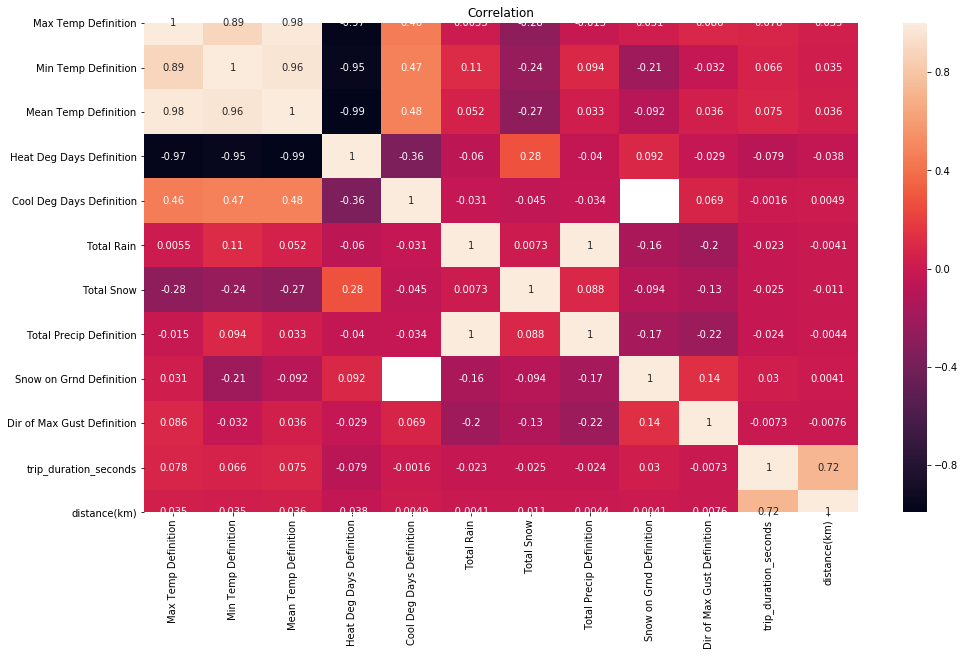

In [30]:
plt.figure(figsize=(16, 9))
sns.heatmap(weather_length_corr, annot=True)
plt.title('Correlation')
plt.show()

To analysis the relationship between weather and trip length, I used correlation matrix to visualize the data we have. The plot under the correlation matrix is the heat map of that matrix which is easier to visualze the data. According to the result we have, based on trip duration, temperature shows the strongest relation among all of the weather variables based on both benchmarks of definitions of trip length. (i.e. trip duration and trip distance) because the absolute value of correlation coefficient are the greatest. However, the greatest absolute value of correlation coefficients 0.038, which means the impact of weather on rideship is not that huge.

## Conclusion

Based on this report, I can summarize the conclusions as following:
- There is a strong relationship between distance and trip duration which are the two variables defined to measure the trip length.
- There are more member user than casual users and member users seems have a lower trip duration than casual users while member users and casual users share the same trip distance. However this result may be influenced by the definition of trip distance, which is the limitaion of this methods.
- Temperature is the strongest factor that may have impact on rideship among all of the variables corresponding to weather. However based on the absolute value of correlation coefficient observed, temperature also does not have a huge impact on rideship, which indicates weather is not a deal for those user who need to ride share bikes in Toronto.

## Further Steps

In this part, I will give several suggestions that can be done according to the conclusions:
- Since casual users seems to take longer trip than member users, then we can also do some analysis in the frequency of rideship between these two types of user if possible, finally this report can help company to adjust policy of applying to member user for casual users.
- Weather does not have a huge impact on trip length, then we can do analysis according to the usage of bikes in different season or weather, then the number of share bikes of each station can be allocated relating to weather properly.